In [1]:
import locale

locale.setlocale(locale.LC_ALL, 'C')
from tesserocr import PyTessBaseAPI, PSM, OEM, RIL, iterate_level, iterate_choices
from PIL import Image

# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import pytesseract
import argparse
import cv2
import imutils
from imutils import contours

In [2]:
def decode_predictions(scores, geometry):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the
        # geometrical data used to derive potential bounding box
        # coordinates that surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability,
            # ignore it
            if scoresData[x] < args["min_confidence"]:
                continue

            # compute the offset factor as our resulting feature
            # maps will be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and
            # then compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height
            # of the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates
            # for the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score
            # to our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # return a tuple of the bounding boxes and associated confidences
    return (rects, confidences)

In [3]:
def resize_image(im, max_side_len=2400):
    '''
    resize image to a size multiple of 32 which is required by the network
    :param im: the resized image
    :param max_side_len: limit of max image size to avoid out of memory in gpu
    :return: the resized image and the resize ratio
    '''
    h, w, _ = im.shape

    resize_w = w
    resize_h = h

    # limit the max side
    if max(resize_h, resize_w) > max_side_len:
        ratio = float(max_side_len) / resize_h if resize_h > resize_w else float(max_side_len) / resize_w
    else:
        ratio = 1.
    resize_h = int(resize_h * ratio)
    resize_w = int(resize_w * ratio)

    resize_h = resize_h if resize_h % 32 == 0 else (resize_h // 32 + 1) * 32
    resize_w = resize_w if resize_w % 32 == 0 else (resize_w // 32 + 1) * 32
    im = cv2.resize(im, (int(resize_w), int(resize_h)))

    ratio_h = resize_h / float(h)
    ratio_w = resize_w / float(w)

    return im, (ratio_h, ratio_w)

In [4]:
def recognize_single(image):
    """
    :param image:
    :return:
    """
    # TODO add stop symbols
    img = Image.fromarray(image)
    with PyTessBaseAPI(lang='eng', psm=PSM.SINGLE_WORD) as api:
        api.SetImage(img)
        result = api.GetUTF8Text()
        return result, api.GetThresholdedImage()

In [6]:
args = dict(image='./images/karta.png', east='./frozen_east_text_detection.pb', padding=0.05, min_confidence=0.5)

image = cv2.imread(args["image"])
orig = image.copy()

(origH, origW) = image.shape[:2]

image, (rH, rW) = resize_image(image, max_side_len=2400)
(H, W) = image.shape[:2]

layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

net = cv2.dnn.readNet(args["east"])
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)

results = []

for (startX, startY, endX, endY) in boxes:
    startX = int(startX / rW)
    startY = int(startY / rH)
    endX = int(endX / rW)
    endY = int(endY / rH)

    dX = int((endX - startX) * args["padding"])
    dY = int((endY - startY) * args["padding"])

    startX = max(0, startX - dX)
    startY = max(0, startY - dY)
    endX = min(origW, endX + (dX))
    endY = min(origH, endY + int(dY * 2))

    roi = orig[startY:endY, startX:endX]
#     config = ("-l eng --oem 1 --psm 8")
#     text = pytesseract.image_to_string(roi, config=config)
    text = ''
    results.append(((startX, startY, endX, endY), text))

results = sorted(results, key=lambda r: r[0][1])

In [12]:
def prepare_ref(reference_path):
    ref = cv2.imread(reference_path)
    ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
    ref = cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)[1]

    refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    refCnts = refCnts[0] if imutils.is_cv2() else refCnts[1]
    refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
    digits = {}

    for (i, c) in enumerate(refCnts):
        (x, y, w, h) = cv2.boundingRect(c)
        roi = ref[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))

        digits[i] = roi
    return digits

In [13]:
digits = prepare_ref('./ocr_a_reference.png')

Credit Card #: 5209858800000000


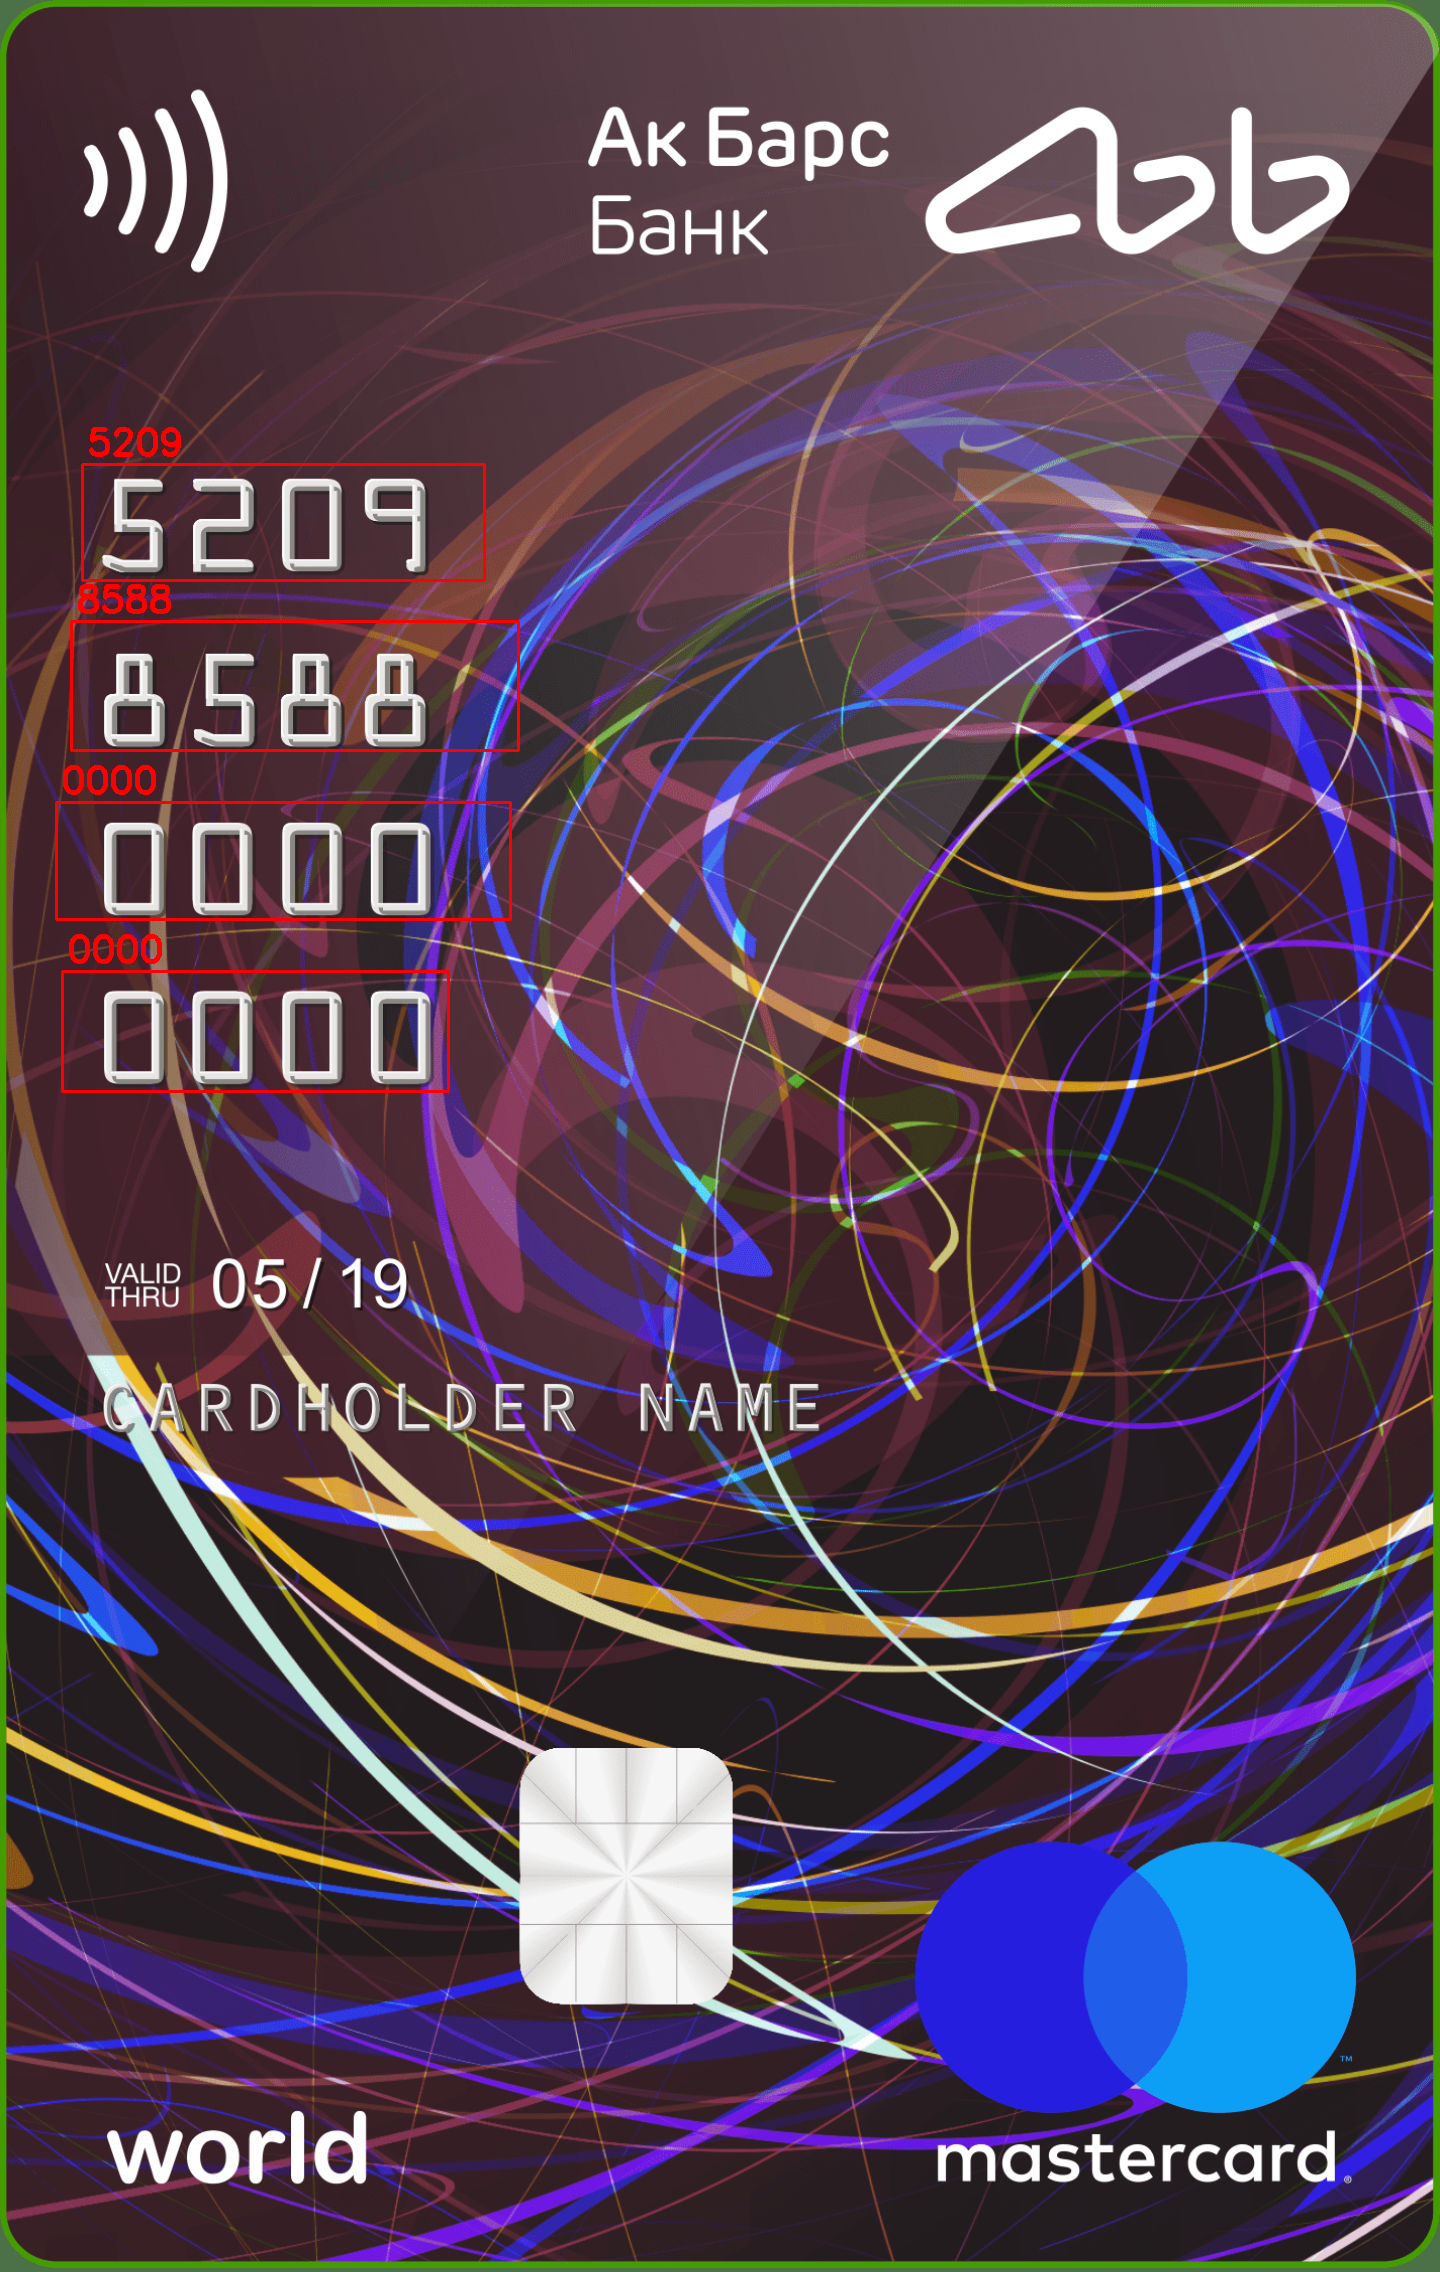

In [14]:
all_scores = []
output = []
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
groups = []
for (i, ((gX, gY, eW, eH), _)) in enumerate(results):
    gW = eW - gX
    gH = eH - gY
    groupOutput = []

    group = gray[max(gY - 5, 0):min(gY + gH + 5, gray.shape[0]), max(gX - 5, 0):min(gX + gW + 5, gray.shape[1])]
    group_small = cv2.resize(group, dsize=None, fx=0.2, fy=0.2)    

    group = cv2.resize(group, dsize=None, fx=0.5, fy=0.5)

    group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    group = cv2.morphologyEx(group, cv2.MORPH_OPEN, sqKernel)
    
    digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digitCnts = digitCnts[0] if imutils.is_cv2() else digitCnts[1]
    if len(digitCnts) == 0:
        continue
    digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]
    appended = False

    for c in digitCnts:

        (x, y, w, h) = cv2.boundingRect(c)
        roi = group[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))

        scores = []

        for (digit, digitROI) in digits.items():
            result = cv2.matchTemplate(roi, digitROI, cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)
            
        final_score = np.max(scores)
        
        all_scores.append(scores)
        
        if final_score > 40000000:
            groupOutput.append(str(np.argmax(scores)))
            appended = True

    if appended:
        cv2.rectangle(image, (gX - 5, gY - 5), (gX + gW + 5, gY + gH + 5), (255, 0, 0), 2)
        cv2.putText(image, "".join(groupOutput), (gX, gY - 15), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 0, 0), 3)
        output.extend(groupOutput)
        appended = False
        
print("Credit Card #: {}".format("".join(output)))
Image.fromarray(image)